## Sentiment Analysis Using Multinomial Logistic Regression

In this project, we will use the Twitter Tweets Sentiment Dataset for sentiment analysis with multinomial logistic regression to classify tweets as positive, negative, or neutral.

The Twitter Tweets Sentiment Dataset comprises 27,481 tweets with 8,582 positive tweets, 7,781 negative tweets, and 11,118 neutral tweets. The corpus comprises the following columns:

- textID: This is the unique ID of the tweet.
- text: This is the complete text of the tweet.
- selected_text: This is a word or phrase selected from the tweet that expresses the sentiment.
- sentiment: This is the sentiment of the tweet (positive, negative, or neutral).

### Import Libraries



In [3]:
import string # to perform common string operations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # to plot results and visualize metrics
from tqdm import tqdm # to show progress bar during model training

# ======= For Modelling ------------------
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

### Load the Dataset.

This is a modifed data of actual data, Here in the import file tweets.csv, only two columns 'sentiment' and 'tweet'

In [5]:
df_tweet = pd.read_csv(r'./usercode/Tweets.csv')

df_tweet.head(3)

,sentiment,tweet
0,neutral,Happy Monday tweeples... hope it wasn`t to har...
1,negative,I can`t believe I thought I had a morning shif...
2,neutral,So its Superstar Sunday? is one superstar I k...


### Remove Punctuation from Tweets

Remove the punctuation characters from the tweets. This will help simplify the data since punctuation marks do not usually carry significant meaning in the context of text analysis. This will also reduce noise in the data and the dimensionality of the feature space, which can lead to a more efficient and effective model.

Create a function that takes a string text as input and removes any punctuation characters from it. Apply the function to the first column, “tweet,” of the DataFrame. 

In [6]:

# Define a function to remove punctuation from a string
def remove_punctuation(text):
    return ''.join([char for char in text if char not in string.punctuation])

# Apply the function to the first column of the DataFrame
df_tweet.iloc[:, 1] = df_tweet.iloc[:, 1].apply(remove_punctuation)

# Print the Dataframe head
print(df_tweet.head())

  sentiment                                              tweet
0   neutral  Happy Monday tweeples hope it wasnt to hard to...
1  negative  I cant believe I thought I had a morning shift...
2   neutral  So its Superstar Sunday  is one superstar I kn...
3  positive     yay i hit 50 subscribers on youtube go me  lol
4   neutral                                 Today  marking 135


### Split Tweets into a Bag of Words

We will split each string value in the "tweet" column into a bag of words and update the column with modified values

In [7]:
# Split each tweet into a bag of words
df_tweet['tweet'] = df_tweet['tweet'].apply(lambda x: x.split())

# Print the DataFrame head
print(df_tweet.head())

  sentiment                                              tweet
0   neutral  [Happy, Monday, tweeples, hope, it, wasnt, to,...
1  negative  [I, cant, believe, I, thought, I, had, a, morn...
2   neutral  [So, its, Superstar, Sunday, is, one, supersta...
3  positive  [yay, i, hit, 50, subscribers, on, youtube, go...
4   neutral                              [Today, marking, 135]


###  Create a Vocabulary and Remove Stop Words

Stop words are common words in a language (e.g., “the,” “is,” “and,” etc.) that do not carry significant meaning and are often used in various contexts. Removing stop words helps to reduce noise in the text data, as these words are unlikely to contribute much to the overall understanding or sentiment of the tweet. Furthermore, by removing them, **you can reduce the size of the feature space and the computational resources required for training and inference**

In [8]:
# Count occurences of each word

vocabulary_dict = {}
for row in df_tweet['tweet']:
    for word in row:
        if word.lower() in vocabulary_dict:
            vocabulary_dict[word.lower()] += 1
        else:
            vocabulary_dict[word.lower()] = 1

# Remove the stop words
# Sort the dictionary by its values x[1] in descending order
vocabulary_dict = sorted(vocabulary_dict.items(), key=lambda x: x[1], reverse=True)

# Remove the 100 most frequent words
vocabulary_dict = vocabulary_dict[100:]

# Store the remaining words and their frequencies in a new dictionary
vocabulary_dict = dict(vocabulary_dict)

# Extract keys from the dictionary
vocabulary = list(vocabulary_dict.keys())

### Create Feature Vectors

Use it to create feature vectors for the tweets. Then convert the resulting sparse matrix to a dense NumPy array. This array will later be used for training and testing the model.


In [9]:
# Extract tweets and convert to lowercase
# convert each word to lowercase and join them back into a string
tweets = [' '.join([word.lower() for word in tweet]) for tweet in df_tweet['tweet']]

# Create the CountVecttorizer with the vocabulary
# Tokenize the tweets and create feature vector based on the vocabulary
# This will be a sparse matrix representation of the tweets
vectorizer = CountVectorizer(vocabulary=vocabulary)

# Fit and transform the tweets into feature vectors
tweet_vectors = vectorizer.fit_transform(tweets)

# Convert the tweet_vectors to NumPy array
X = tweet_vectors.toarray()

# Print the NumPy array
print(X)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]]


### Map and Extract the Sentiment Column

Map the sentiment labels in the “sentiment” column of the DataFrame to numerical values. Then extract the mapped values into a NumPy array. This mapping of string labels to numerical values ensures compatibility with the model and allows for effective processing. It also enables the use of categorical encoding techniques, such as one-hot encoding,

1. Replace the original sentiment labels in the “sentiment” column with their corresponding integer values (2 for positive, 1 for neutral, and 0 for negative).
2. Extract the values from the modified “sentiment” column into a NumPy array.



In [10]:
# Define the mapping dictionary
mapping = {'positive': 2, 'neutral': 1, 'negative': 0}

# Map the values in the column using the mapping dictionary
df_tweet['sentiment'] = df_tweet['sentiment'].map(mapping)

# Extract sentiment from the dataframe
y = df_tweet['sentiment'].values

### Split the Dataset into Training and Test Sets

Split the feature vectors and the corresponding sentiment labels into training and testing subsets in an 80:20 ratio, with **stratified sampling** to preserve the distribution of sentiment labels. The training dataset will be used to train the model, and the testing dataset will be used to evaluate the model’s performance after training is complete as an independent evaluation set

The training dataset will be used to train the model, and the testing dataset will be used to evaluate the model’s performance after training is complete as an independent evaluation set.

**Stratified sampling** ensures that the splitting process maintains the same proportion of sentiment labels in training and testing subsets. This is useful when dealing with imbalanced datasets to ensure a representative distribution of the classes in the subsets

In [11]:
# Split the data into training and testing subsets with stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Print the shapes of resulting subsets
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4800, 10563)
(1200, 10563)
(4800,)
(1200,)


### Define the Weights Initialization Function

A function `initialize_weights()` that takes two parameters: `n_features` and `n_classes`. Inside the function: 

1. Create a NumPy array of zeros with a shape of `(n_features, n_classes)`, where `n_features` represents features, and `n_classes` represents the number of classes


In [12]:
def initialize_wieghts(n_features, n_classes):
    return np.zeros((n_features, n_classes))

### Define One-Hot Encoding Function

The `one_hot_encode()` function to convert an array of class labels `y` into a one-hot encoded representation. The resulting array will have dimensions `(n_samples, n_classes)`, where each row will represent a sample and each column will represent a class. The elements corresponding to the class labels in `y` will be marked as `1`, while the rest will be `0`.



In [13]:
def one_hot_encode(y, n_classes):
    n_samples = len(y)
    
    # Numpy zeros array
    y_encoded = np.zeros((n_samples, n_classes))

    # Each sample with corresponding class position with 1 and leaving the rest as 0
    for i in range(n_samples):
        y_encoded[i, y[i]] = 1
    
    return y_encoded

### Define the Softmax Function

write the `softmax()` function that takes an input array x, computes the softmax activation for each element, and returns the resulting array of normalized values. The softmax function is commonly used in mult(iclass classification problems to convert raw scores or logits into probabilities representing class probabilities. It is defined as :

$softmax(x_i) = exp(x_i) / sum(exp(x_j))$

Here,
- $softmax(x_i)$ is the value of the softmax function for the ith element of the input vector,
- $exp(x_i)$ represents the exponential function applied to the ith element of the input vector x,
- $sum(exp(x_j))$ is the sum of the exponential values for all elements in the input vector x


In [14]:
def softmax(x):
    exp = np.exp(x)
    # sum of exponential values along the second axis (axis=1) with the axis 
    # keepdims parameters to ensure the resulting sum has the same dimensions as the input array
    return exp / np.sum(exp, axis=1, keepdims=True)

### Define the Gradient Descent Function

The `gradient_descent()` function to apply gradient descent to update the weights and the bias of our model based on the feature matrix X, the one-hot encoded target values y_encoded, the initial weights, the initial bias, and the learning rate

1. Compute the scores by performing matrix multiplication between the feature matrix `X` and the weights matrix, and add the bias term. Store the result in the scores array.
2. Calculate the probabilities by applying the `softmax` function to the scores array.
3. Compute the error by subtracting the one-hot encoded target values `y_encoded` from the predicted probabilities.
4. Compute the gradient of the weights by multiplying the transpose of the feature matrix `X` with the error and dividing it by the number of samples.
5. Compute the gradient of the bias by summing the error along the first axis and dividing it by the number of samples.
6. Update the weights by subtracting the learning rate multiplied by the gradient of the weights.
7. Update the bias by subtracting the learning rate multiplied by the bias gradient.

In [25]:
def gradient_descent(X, y_encoded, weights, bias, learning_rate):

    n_samples = len(X)
    scores = np.dot(X, weights) + bias # X will shape -> (n_sample, n_features) weights with shape of W = (n_features, n_classes)
    probabilities = softmax(scores) # softmax(x) = e^x_i / np.sum(e^x_j)
    error = probabilities - y_encoded
    dw = np.dot(X.T, error) / n_samples # Gradient of weights -> delta_w = dL/dw, SO change in L wrt to w, to move in direction that minimizes the L
    db = np.sum(error, axis=0) / n_samples 
    weights -= learning_rate * dw
    bias -= learning_rate * db
    
    return weights, bias


### Define the Training Function


In [26]:
def train_mulinomial_logistic_regression(X, y, learning_rate, max_iterations):
    n_samples, n_features = np.shape(X) # To get the number of samples, and features
    n_classes = len(np.unique(y)) # Number of unique classes

    weights = initialize_wieghts(n_features, n_classes)
    bias = np.zeros(n_classes) # to initialize the bias vector as array of zeros with length equal to number of classes
    y_encoded = one_hot_encode(y, n_classes) # Encode the target array y into a one-hot encoded representation

    # Update the weights and bias by calling the gradient_descent function max_iterations times
    for _ in tqdm(range(max_iterations), desc="Training", unit='iteration'):
        weights, bias = gradient_descent(X, y_encoded, weights, bias, learning_rate)

        return weights, bias

### Define the Prediction Function

Function that takes a feature matrix X, the weights, and the bias of our multinomial logistic regression model. It’ll compute the scores and probabilities for each sample and return the predicted class labels based on the maximum probability for each sample.

In [27]:
def predict(X, weights, bias):
    
    scores = np.dot(X, weights) + bias
    probabilities = softmax(scores)
    
    # To find the index of the mazimum probability for each sample along the second axis
    return np.argmax(probabilities, axis=1)

###  Train the Model

Invoke the train_multinomial_logistic_regression() function to train the multinomial logistic regression model using the training data X_train and y_train.


In [28]:
# Initialize learning rate and maximum iterations
learning_rate = 0.31101
max_iterations = 500

# Train the model
weights, bias = train_mulinomial_logistic_regression(X_train, y_train, learning_rate, max_iterations)

Training:   0%|          | 0/500 [00:00<?, ?iteration/s]


### Test the Model

In [30]:
# Test the model
y_pred = predict(X_test, weights, bias)

# Print the predicted class labels
print(y_pred)

[0 2 0 ... 0 1 1]


### Generate the Confusion Matrix and Classification Report

This report will include metrics for each class label, providing insights into precision, recall, F1-score, and support.

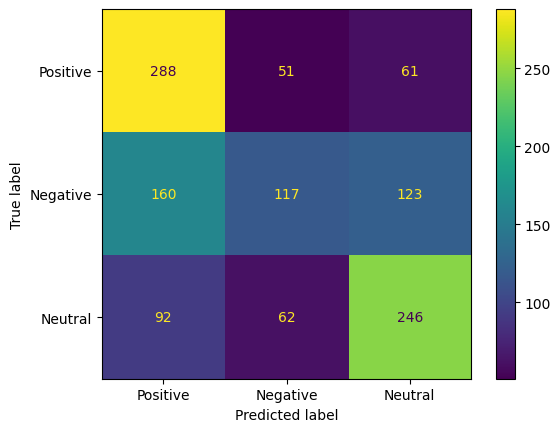

              precision    recall  f1-score   support

    Positive       0.53      0.72      0.61       400
    Negative       0.51      0.29      0.37       400
     Neutral       0.57      0.61      0.59       400

    accuracy                           0.54      1200
   macro avg       0.54      0.54      0.53      1200
weighted avg       0.54      0.54      0.53      1200



In [31]:
# Generate a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
labels = ["Positive", "Negative", "Neutral"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()

## Generate a classification report
print(classification_report(y_test, y_pred, target_names=['Positive', 'Negative', 'Neutral']))